In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import gpxpy
from datetime import datetime
import numpy as np
import scipy.fftpack

In [2]:
gpx = gpxpy.parse(open('20191209BUS23EW.gpx'))

print("{} track(s)".format(len(gpx.tracks)))
track = gpx.tracks[0]

print("{} segment(s)".format(len(track.segments)))
segment = track.segments[0]

print("{} point(s)".format(len(segment.points)))

1 track(s)
1 segment(s)
963 point(s)


In [3]:
data = []
segment_length = segment.length_3d()
for point_idx, point in enumerate(segment.points):
    data.append([point.longitude, point.latitude,
                 point.elevation, point.time, segment.get_speed(point_idx)])
    
from pandas import DataFrame

columns = ['Longitude', 'Latitude', 'Altitude', 'Time', 'Speed']
df = DataFrame(data, columns=columns)
df.head()

Longitude   Latitude  Altitude                             Time      Speed
0 -83.720873  42.298079   237.637 2019-12-09 20:36:41.958000+00:00   7.167167
1 -83.720952  42.298101   235.948 2019-12-09 20:36:42.986000+00:00   7.167165
2 -83.721089  42.298110   228.952 2019-12-09 20:36:43.971000+00:00  14.406155
3 -83.721258  42.298088   226.095 2019-12-09 20:36:44.971000+00:00  12.982798
4 -83.721390  42.298124   226.019 2019-12-09 20:36:45.971000+00:00  12.417379

In [4]:
#from 2019-12-09 20:40:53
#to 2019-12-09 20:51:47
df_GPS = df[211:211+653]
df_GPS = df_GPS.reset_index()
df_GPS = df_GPS.drop(columns='index')

In [5]:
for i,j in enumerate(df_GPS['Time']):
    df_GPS.loc[i,'s'] = datetime.timestamp(j)

In [6]:
import numpy as np
import seawater as sw
from oceans.filters import smoo1

_, angles = sw.dist(df_GPS['Latitude'], df_GPS['Longitude'])
angles = np.r_[0, np.deg2rad(angles)]

# Normalize the speed to use as the length of the arrows
r = df_GPS['Speed'] / df_GPS['Speed'].max()
kw = dict(window_len=20, window='hanning')
df_GPS['u'] = smoo1(r * np.cos(angles), **kw)
df_GPS['v'] = smoo1(r * np.sin(angles), **kw)

In [8]:
import mplleaflet
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8,8))
df_GPS = df_GPS.dropna()
ax.plot(df_GPS['Longitude'], df_GPS['Latitude'],
        color='darkorange', linewidth=5, alpha=0.6)
sub = 8
ax.quiver(df_GPS['Longitude'][::sub], df_GPS['Latitude'][::sub], df_GPS['u'][::sub], df_GPS['v'][::sub], color='r', alpha=0.8, scale=20)
mplleaflet.display(fig=fig, tiles='esri_aerial')

/Users/apple/anaconda3/envs/py36/lib/python3.7/site-packages/IPython/core/display.py:689: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


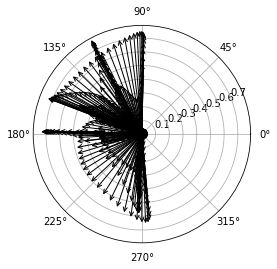

In [9]:
from oceans.ocfis import uv2spdir
u = df_GPS['u']
v = df_GPS['v']
wd, ws = uv2spdir(u,v)
fig, ax = plt.subplots(subplot_kw=dict(polar=True))
kw = dict(arrowstyle="->")
wd = np.deg2rad(wd)
lines = [ax.annotate("", xy=(d, s), xytext=(0, 0), arrowprops=kw) for d, s in zip(wd, ws)]
_ = ax.set_ylim(0, np.max(ws))

In [10]:
df = pd.read_csv('df.csv',header=None)
df = df.iloc[68:,:]
df = df.rename(columns={0:'time',1:'xyz'})

In [11]:
def t2s(t):
    hms = t.str.split(".")
    t2 = pd.DataFrame(hms.values.tolist(), index= hms.index).iloc[:,0]
    t2 = t2.str.split(":")
    h = pd.DataFrame(t2.values.tolist(), index= t2.index).iloc[:,0]
    m = pd.DataFrame(t2.values.tolist(), index= t2.index).iloc[:,1]
    s = pd.DataFrame(t2.values.tolist(), index= t2.index).iloc[:,2]
    return (h.astype(int) * 3600 + m.astype(int) * 60 + s.astype(int))

In [12]:
df['s'] = t2s(df['time'])

In [13]:
acc_index = [x*4 for x in range(int(len(df)/4))]
acceleration = df.iloc[acc_index,:]
gyro_index = [x*4+1 for x in range(int(len(df)/4))]
gyro = df.iloc[gyro_index,:]
mag_index = [x*4+2 for x in range(int(len(df)/4))]
mag = df.iloc[mag_index,:]
temp_index = [x*4+3 for x in range(int(len(df)/4))]
temp = df.iloc[temp_index,:]

In [14]:
acc_df = pd.DataFrame(list(acceleration['xyz'].str.split()))
acc_df = acc_df.iloc[:,[1,4,7]]
acc_df = acc_df.rename(columns={1:'x',4:'y',7:'z'})
acc_df = acc_df.astype(float)
acc_df['s'] = (acceleration.reset_index())['s']
acc_df = acc_df.drop_duplicates('s')
acc_df = acc_df.reset_index()
acc_df = acc_df.drop(columns='index')

In [15]:
gyro_df = pd.DataFrame(list(gyro['xyz'].str.split()))
gyro_df = gyro_df.iloc[:,[2,6,10]]
gyro_df = gyro_df.rename(columns={2:'x',6:'y',10:'z'})
gyro_df = gyro_df.astype(float)
gyro_df['s'] = (gyro.reset_index())['s']
gyro_df = gyro_df.drop_duplicates('s')
gyro_df = gyro_df.reset_index()
gyro_df = gyro_df.drop(columns='index')

In [16]:
mag_df = pd.DataFrame(list(mag['xyz'].str.split()))
mag_df = mag_df.iloc[:,[2,6,10]]
mag_df = mag_df.rename(columns={2:'x',6:'y',10:'z'})
mag_df = mag_df.astype(float)
mag_df['s'] = (mag.reset_index())['s']
mag_df = mag_df.drop_duplicates('s')
mag_df = mag_df.reset_index()
mag_df = mag_df.drop(columns='index')

In [17]:
temp_df = pd.DataFrame(list(temp['xyz'].str.split()))
temp_df = temp_df.iloc[:,2]
temp_df = temp_df.rename(columns={2:'T'})
temp_df = temp_df.astype(float)
temp_df = pd.DataFrame(temp_df)
temp_df['s'] = (temp.reset_index())['s']
temp_df = temp_df.drop_duplicates('s')
temp_df = temp_df.reset_index()
temp_df = temp_df.drop(columns='index')

In [18]:
acc_df = acc_df.rename(columns={'x':'acc_x','y':'acc_y','z':'acc_z'}).iloc[:,:3]
gyro_df = gyro_df.rename(columns={'x':'gyro_x','y':'gyro_y','z':'gyro_z'}).iloc[:,:3]
mag_df = mag_df.rename(columns={'x':'mag_x','y':'mag_y','z':'mag_z'}).iloc[:,:3]
temp_df = temp_df.rename(columns={0:'temp'}).iloc[:,:1]

In [19]:
data = pd.concat([df_GPS,acc_df,gyro_df,mag_df,temp_df], axis=1, join_axes=[df_GPS.index])

In [20]:
plt.rcParams['figure.figsize'] = (18.0, 1.0)
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.dpi'] = 300

Text(0, 0.5, 'acceleration (mg)')

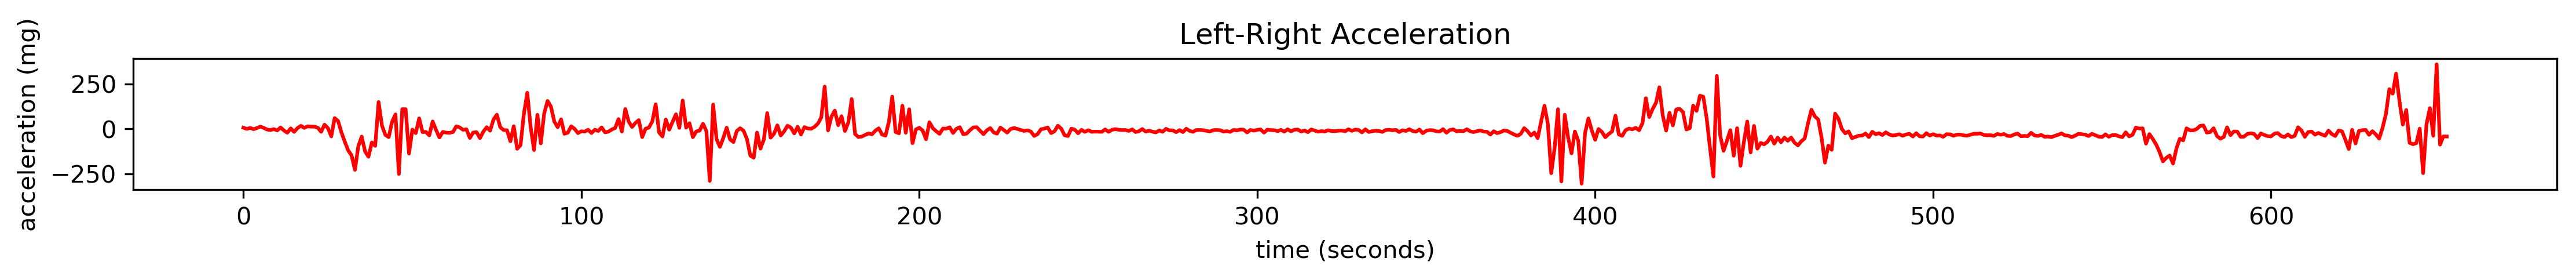

In [21]:
plt.plot(acc_df.loc[:,'acc_x'].values,c='r')
plt.title('Left-Right Acceleration')
plt.xlabel('time (seconds)')
plt.ylabel('acceleration (mg)')

Text(0, 0.5, 'acceleration (mg)')

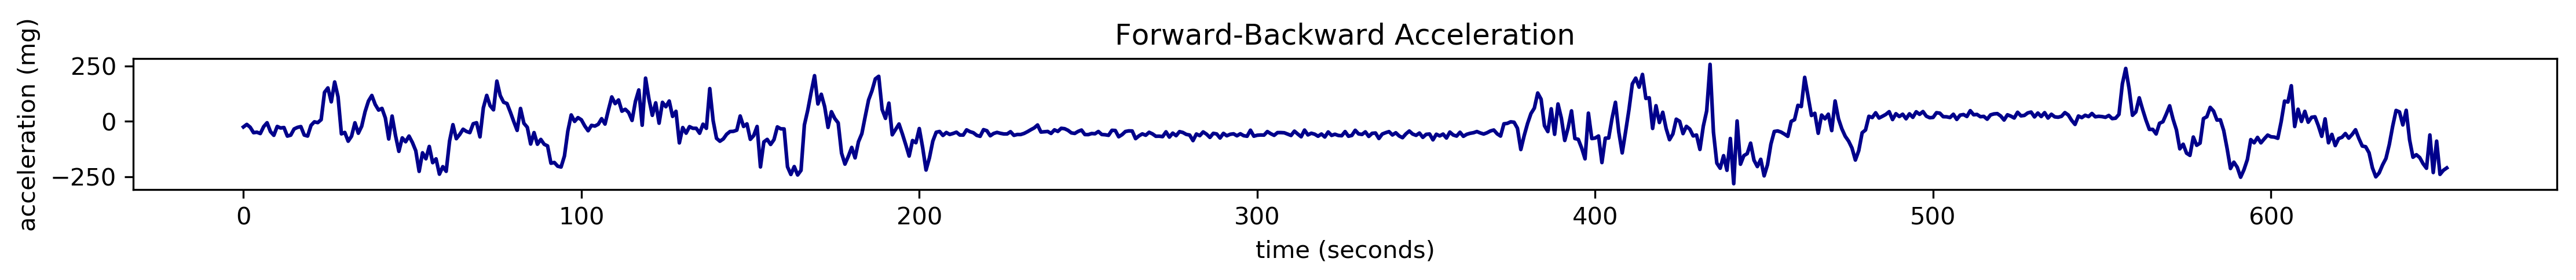

In [22]:
plt.plot(acc_df.loc[:,'acc_y'].values,c='darkblue')
plt.title('Forward-Backward Acceleration')
plt.xlabel('time (seconds)')
plt.ylabel('acceleration (mg)')

Text(0, 0.5, 'acceleration (mg)')

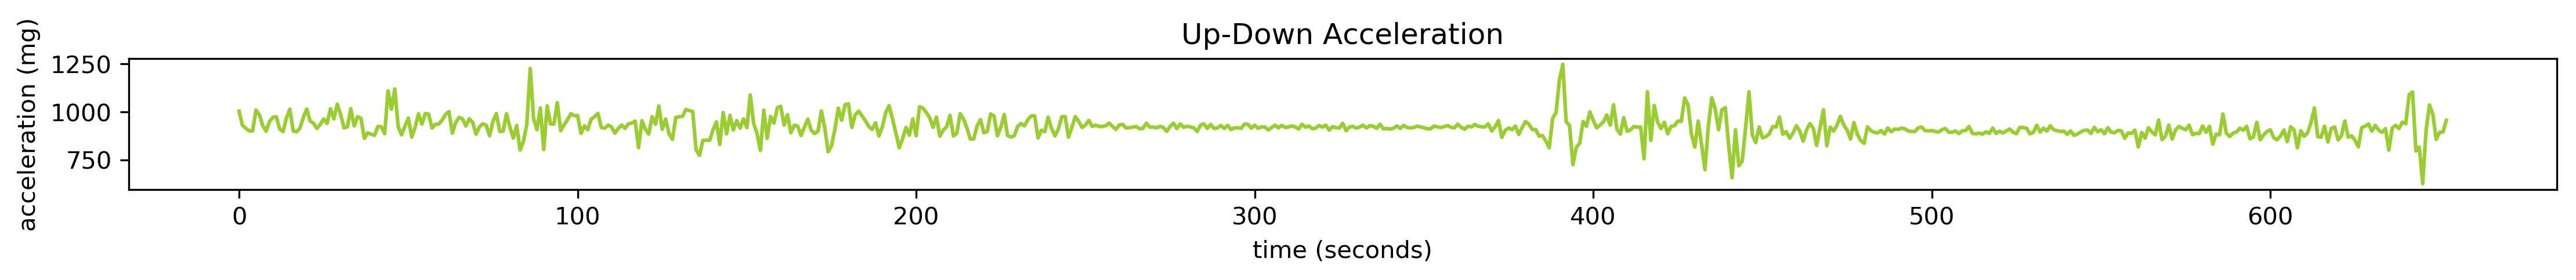

In [23]:
plt.plot(acc_df.loc[:,'acc_z'].values,c='yellowgreen')
plt.title('Up-Down Acceleration')
plt.xlabel('time (seconds)')
plt.ylabel('acceleration (mg)')

Text(0, 0.5, 'x-axis ratation (deg/sec)')

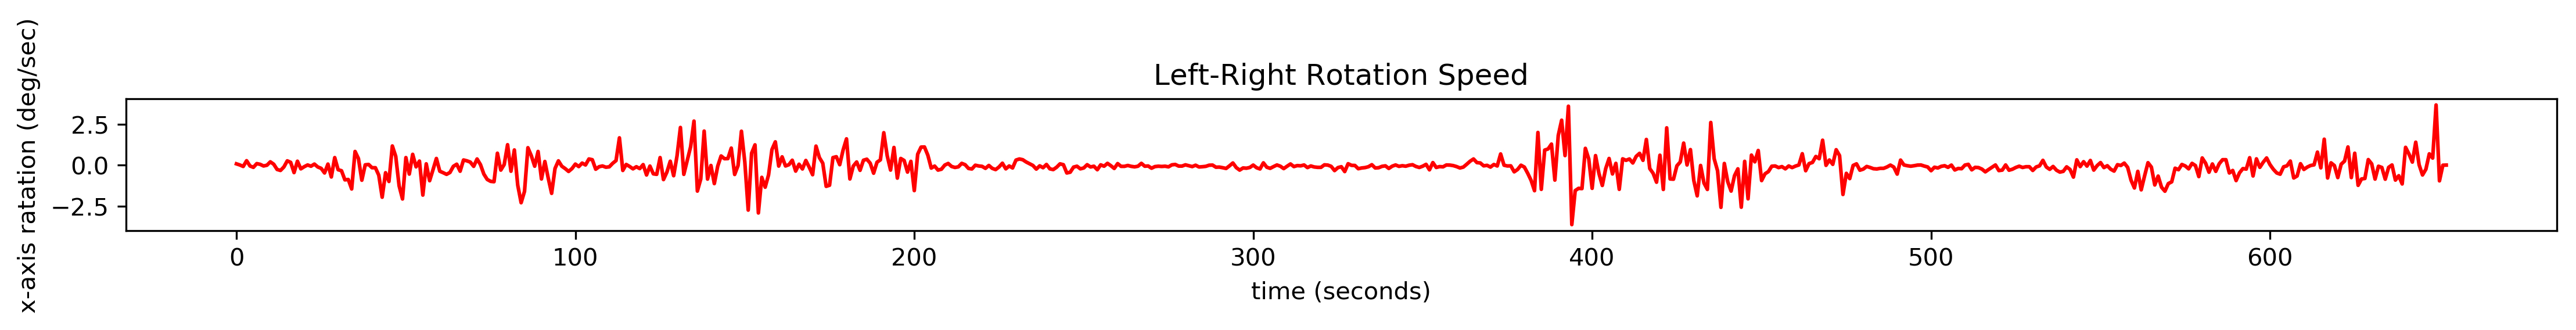

In [24]:
plt.plot(gyro_df.loc[:,'gyro_x'].values,c='r')
plt.title('Left-Right Rotation Speed')
plt.xlabel('time (seconds)')
plt.ylabel('x-axis ratation (deg/sec)')

Text(0, 0.5, 'y-axis ratation (deg/sec)')

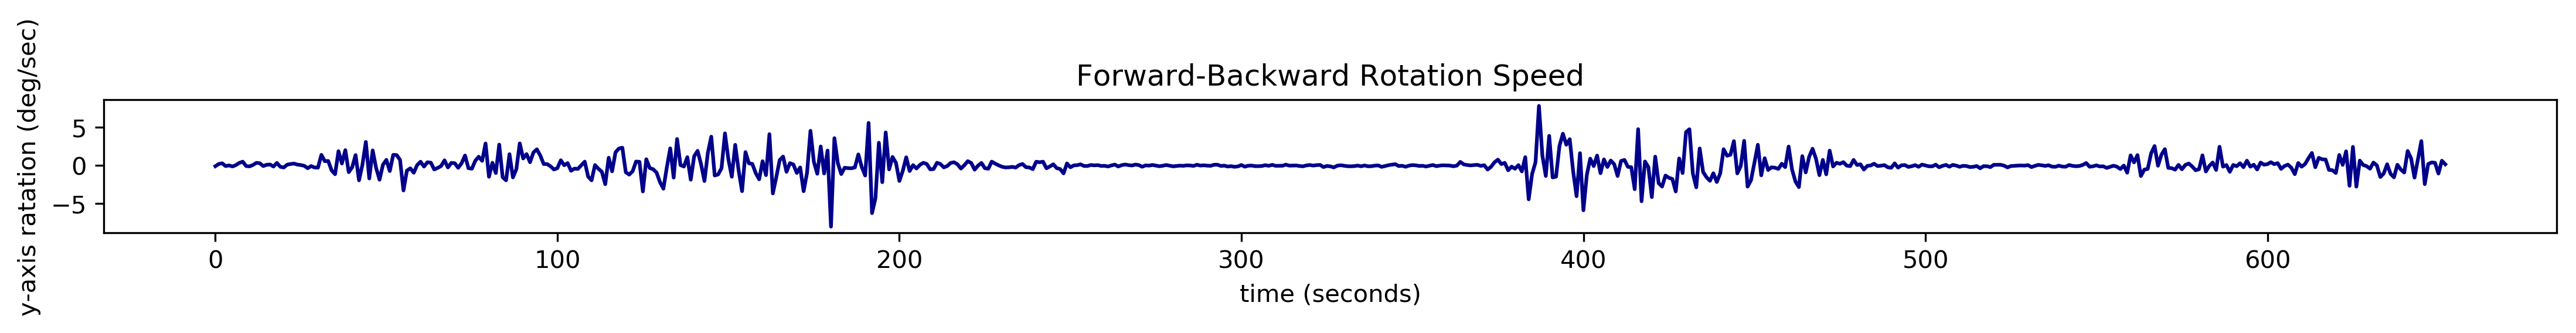

In [25]:
plt.plot(gyro_df.loc[:,'gyro_y'].values,c='darkblue')
plt.title('Forward-Backward Rotation Speed')
plt.xlabel('time (seconds)')
plt.ylabel('y-axis ratation (deg/sec)')

Text(0, 0.5, 'z-axis ratation (deg/sec)')

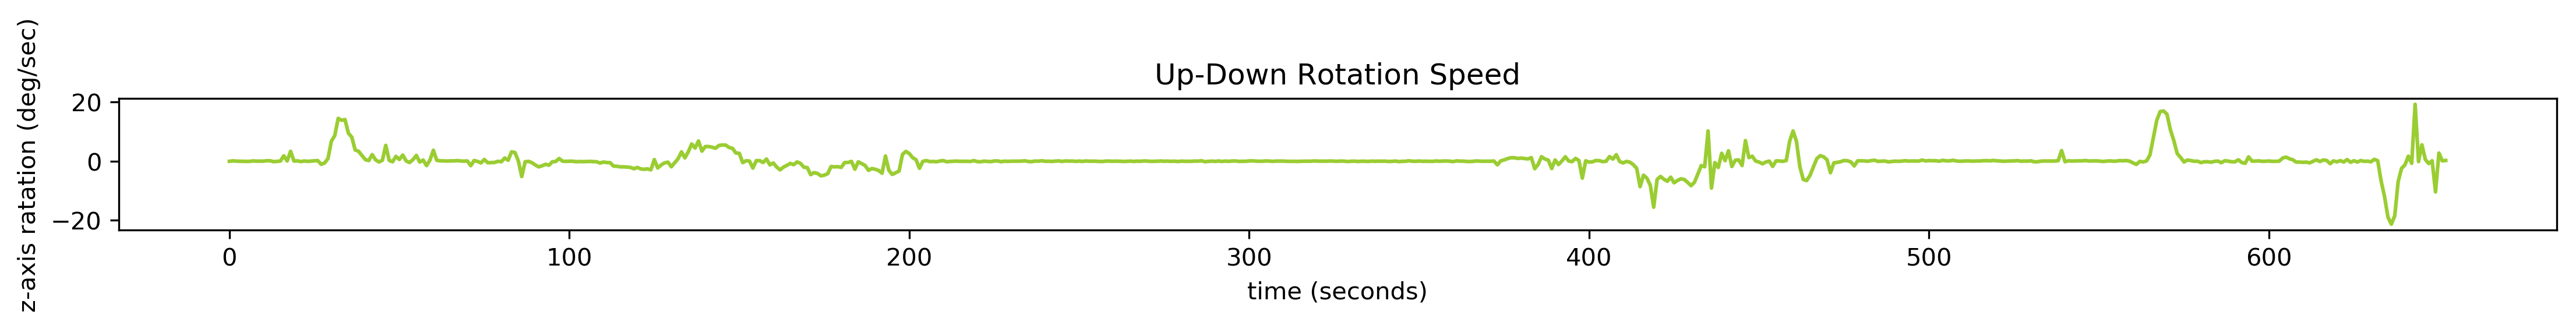

In [26]:
plt.plot(gyro_df.loc[:,'gyro_z'].values,c='yellowgreen')
plt.title('Up-Down Rotation Speed')
plt.xlabel('time (seconds)')
plt.ylabel('z-axis ratation (deg/sec)')

Text(0, 0.5, 'magnetic field (mG)')

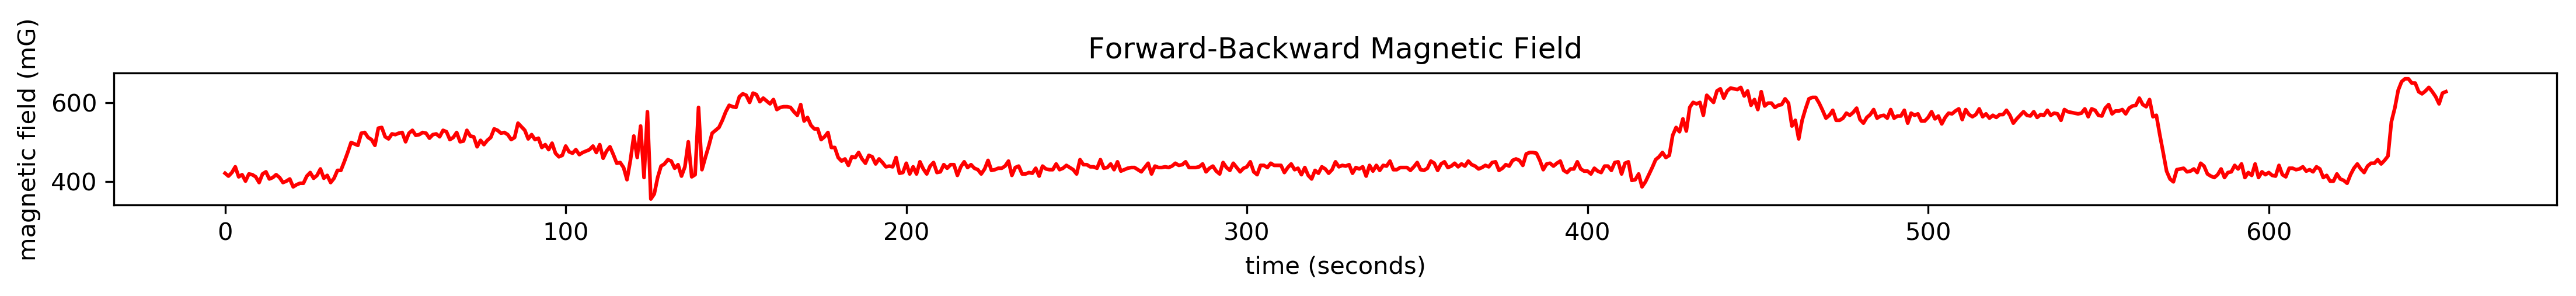

In [27]:
plt.plot(mag_df.loc[:,'mag_x'].values,c='r')
plt.title('Forward-Backward Magnetic Field')
plt.xlabel('time (seconds)')
plt.ylabel('magnetic field (mG)')

Text(0, 0.5, 'magnetic field (mG)')

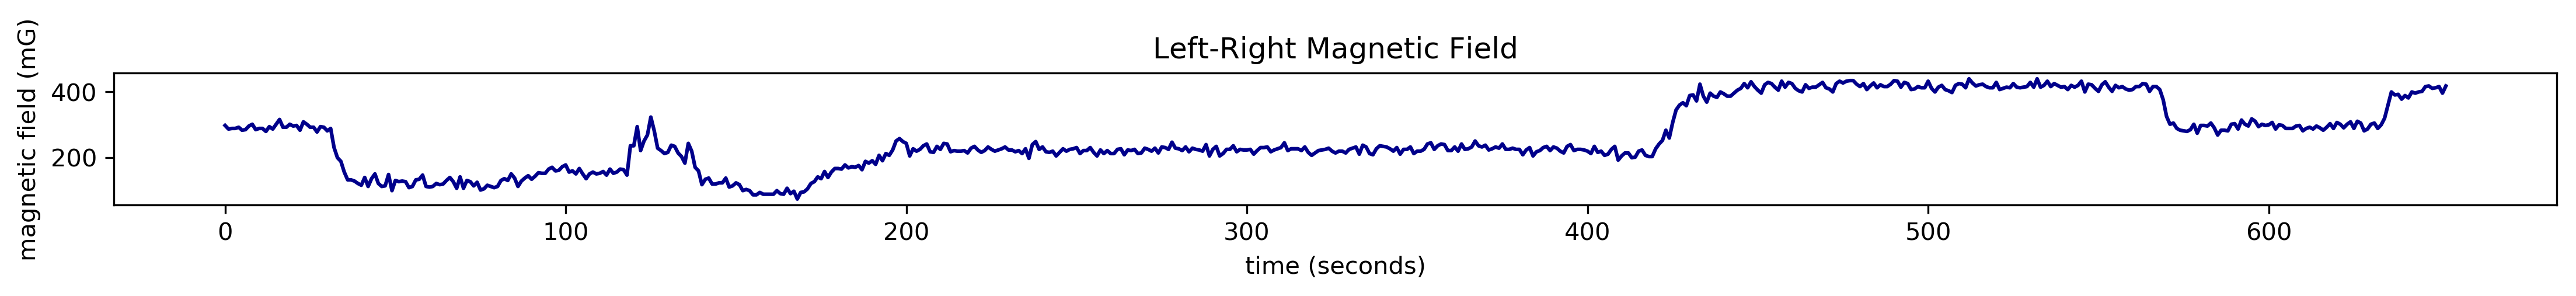

In [28]:
plt.plot(mag_df.loc[:,'mag_y'].values,c='darkblue')
plt.title('Left-Right Magnetic Field')
plt.xlabel('time (seconds)')
plt.ylabel('magnetic field (mG)')

Text(0, 0.5, 'magnetic field (mG)')

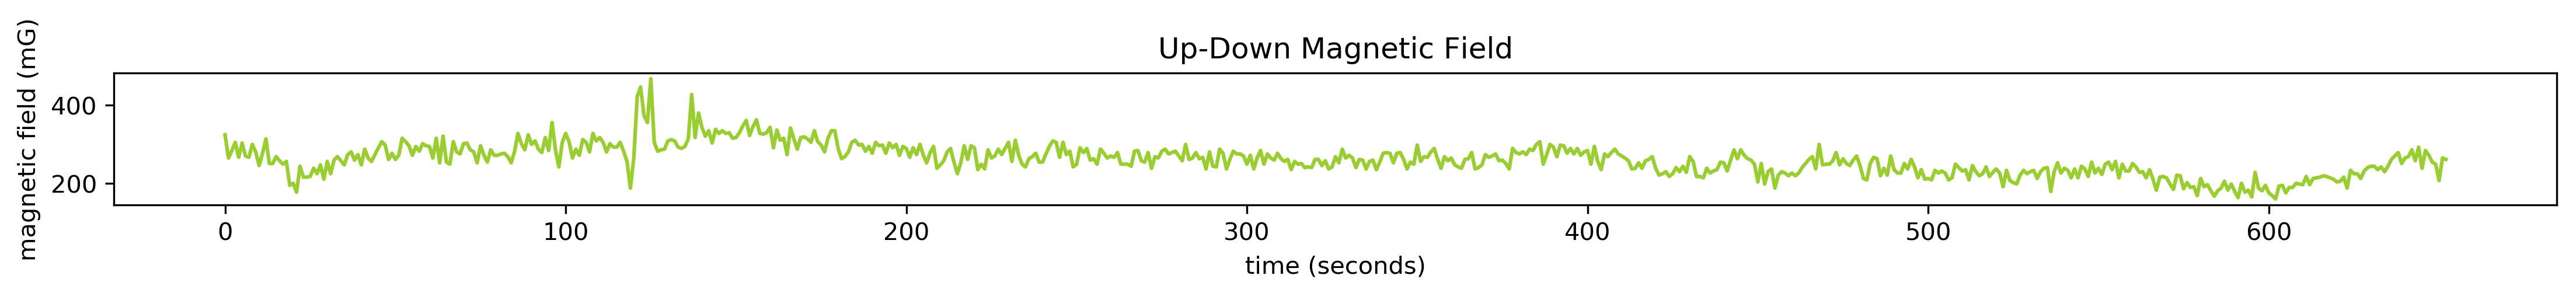

In [29]:
plt.plot(mag_df.loc[:,'mag_z'].values,c='yellowgreen')
plt.title('Up-Down Magnetic Field')
plt.xlabel('time (seconds)')
plt.ylabel('magnetic field (mG)')

In [31]:
import geopandas as gpd
from shapely.geometry import LineString,Point

In [32]:
xyList = [xy for xy in zip(data.Longitude, data.Latitude)]

In [33]:
Data = gpd.GeoDataFrame(data)
Data['geometry'] = None
for i in range(len(xyList)-1):
    Data.loc[i,'geometry'] = LineString([xyList[i],xyList[i+1]])

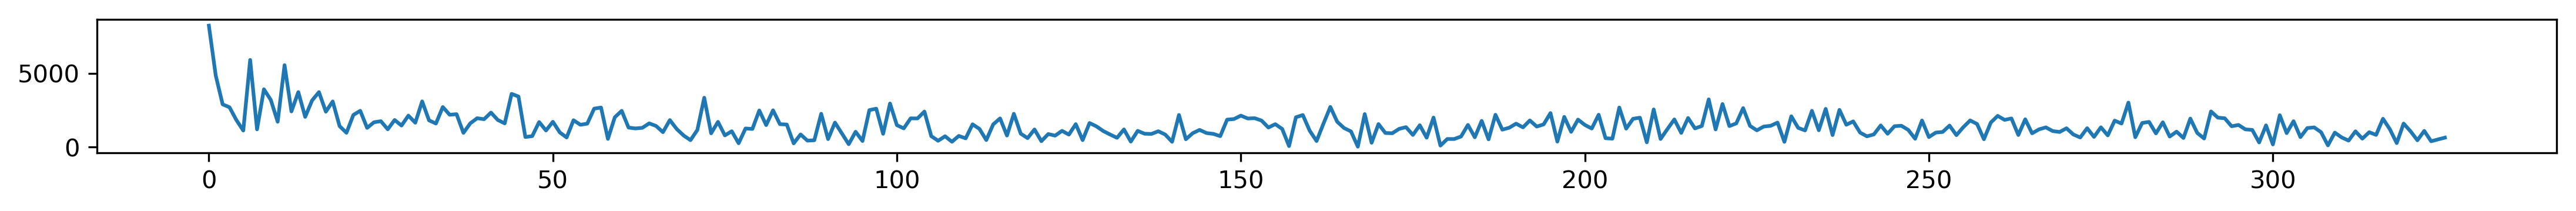

In [34]:
acc_x_fft = scipy.fftpack.fft(Data.loc[:,'acc_x'].values)
plt.plot(np.abs(acc_x_fft)[:int(len(acc_x_fft)/2)])

/Users/apple/anaconda3/envs/py36/lib/python3.7/site-packages/ipykernel_launcher.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  import sys
/Users/apple/anaconda3/envs/py36/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0, 0.5, 'acceleration (mg)')

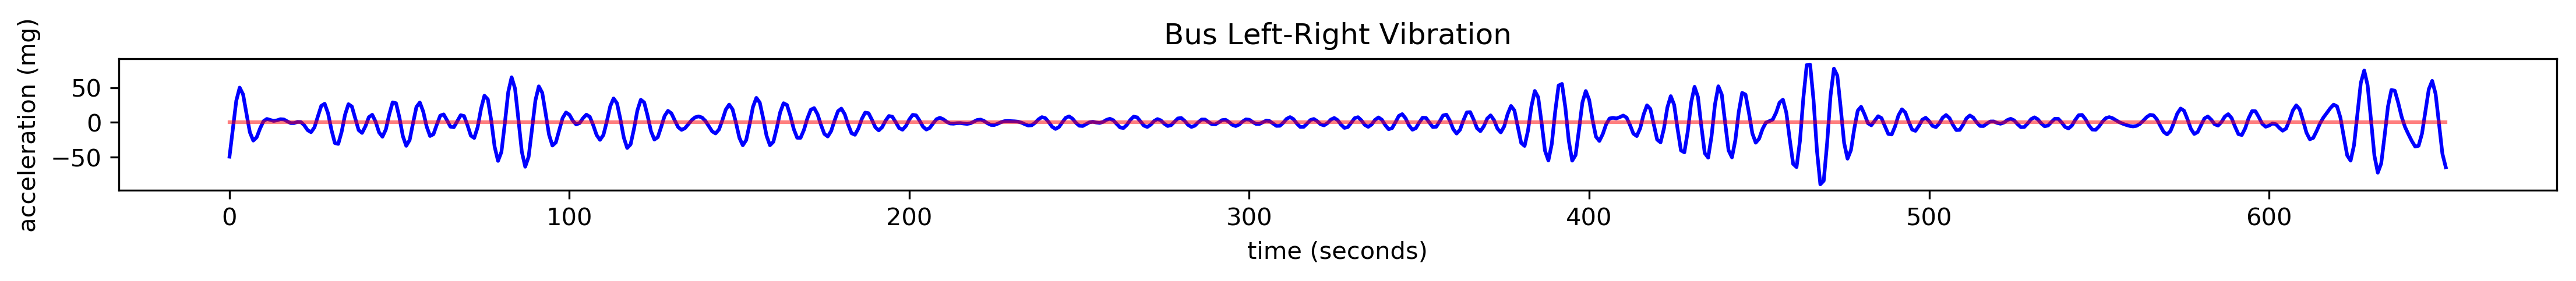

In [35]:
acc_x_fft = scipy.fftpack.fft(Data.loc[:,'acc_x'].values)
b = acc_x_fft
b[100:-100] = 0
b[:60] = 0
b[-60:] = 0
c = scipy.fftpack.ifft(b)
Data['acc_x_oscillation'] = c.astype(float)
plt.plot(c,c='b')
plt.plot(np.zeros(len(c)),alpha=0.5,c='r')
plt.title('Bus Left-Right Vibration')
plt.xlabel('time (seconds)')
plt.ylabel('acceleration (mg)')

/Users/apple/anaconda3/envs/py36/lib/python3.7/site-packages/ipykernel_launcher.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  """


Text(0, 0.5, 'acceleration (mg)')

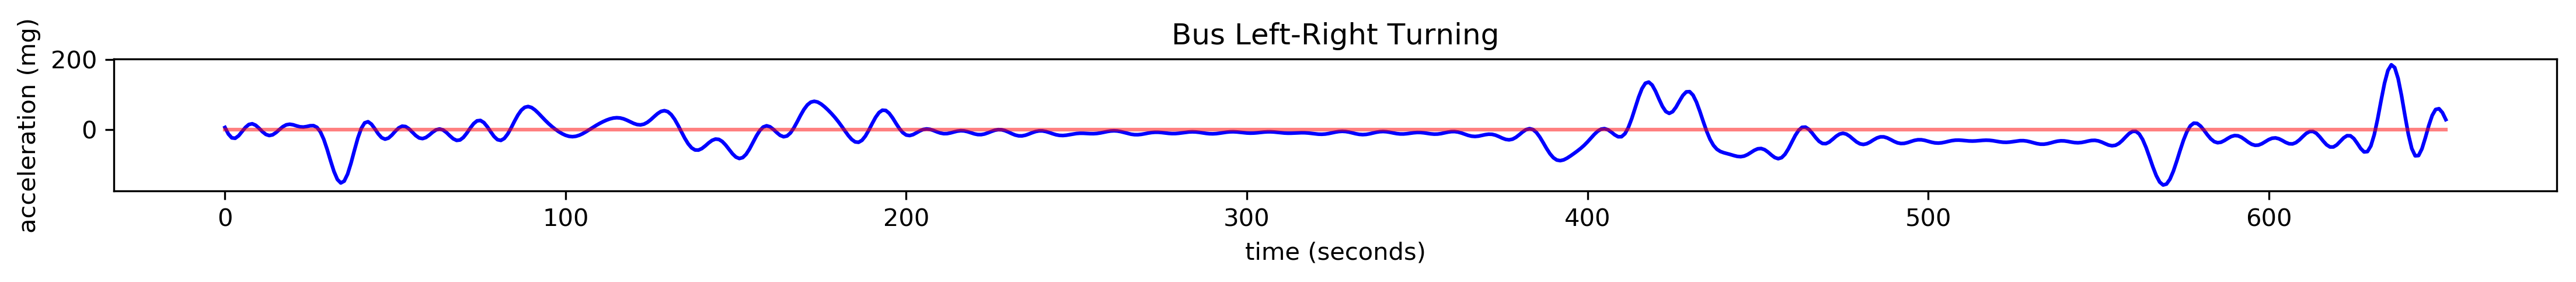

In [36]:
acc_x_fft = scipy.fftpack.fft(Data.loc[:,'acc_x'].values)
b = acc_x_fft
b[60:-60] = 0
c = scipy.fftpack.ifft(b)
Data['acc_x_direction'] = c.astype(float)
plt.plot(c,c='b')
plt.plot(np.zeros(len(c)),alpha=0.5,c='r')
plt.title('Bus Left-Right Turning')
plt.xlabel('time (seconds)')
plt.ylabel('acceleration (mg)')

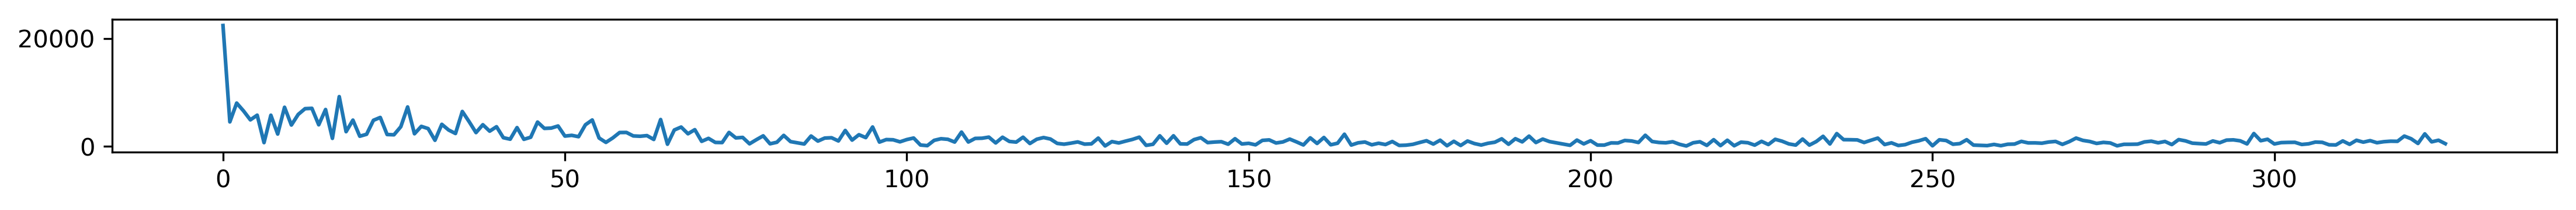

In [37]:
acc_y_fft = scipy.fftpack.fft(Data.loc[:,'acc_y'].values)
plt.plot(np.abs(acc_y_fft)[:int(len(acc_y_fft)/2)])

/Users/apple/anaconda3/envs/py36/lib/python3.7/site-packages/ipykernel_launcher.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  import sys


Text(0, 0.5, 'acceleration (mg)')

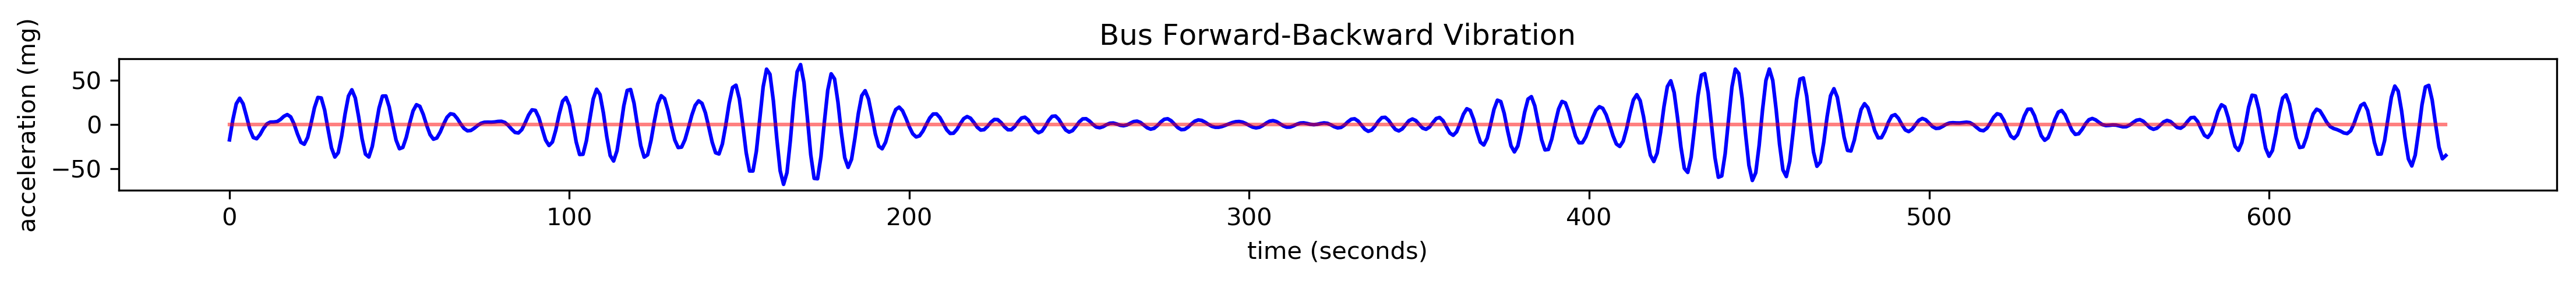

In [38]:
acc_y_fft = scipy.fftpack.fft(Data.loc[:,'acc_y'].values)
b = acc_y_fft
b[80:-80] = 0
b[:60] = 0
b[-60:] = 0
c = scipy.fftpack.ifft(b)
Data['acc_y_oscillation'] = c.astype(float)
plt.plot(c,c='b')
plt.plot(np.zeros(len(c)),alpha=0.5,c='r')
plt.title('Bus Forward-Backward Vibration')
plt.xlabel('time (seconds)')
plt.ylabel('acceleration (mg)')

/Users/apple/anaconda3/envs/py36/lib/python3.7/site-packages/ipykernel_launcher.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  import sys


Text(0, 0.5, 'acceleration (mg)')

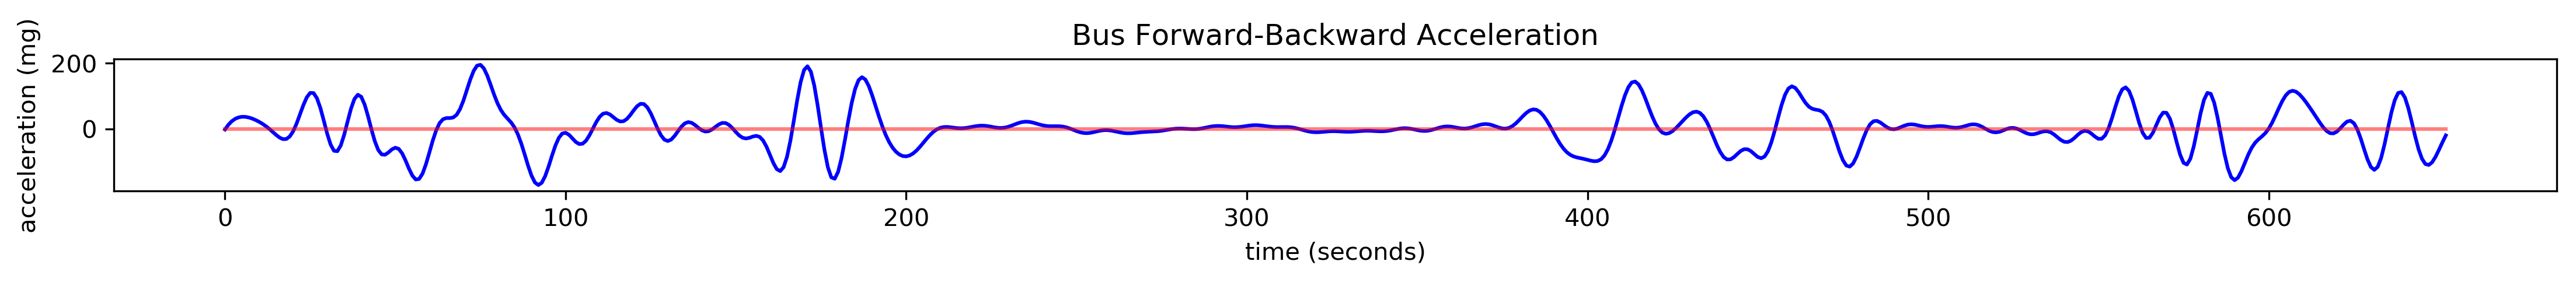

In [39]:
acc_y_fft = scipy.fftpack.fft(Data.loc[:,'acc_y'].values)
b = acc_y_fft
b[60:-60] = 0
b[:10] = 0
b[-10:] = 0
c = scipy.fftpack.ifft(b)
Data['acc_y_fb'] = c.astype(float)
plt.plot(c,c='b')
plt.plot(np.zeros(len(c)),alpha=0.5,c='r')
plt.title('Bus Forward-Backward Acceleration')
plt.xlabel('time (seconds)')
plt.ylabel('acceleration (mg)')

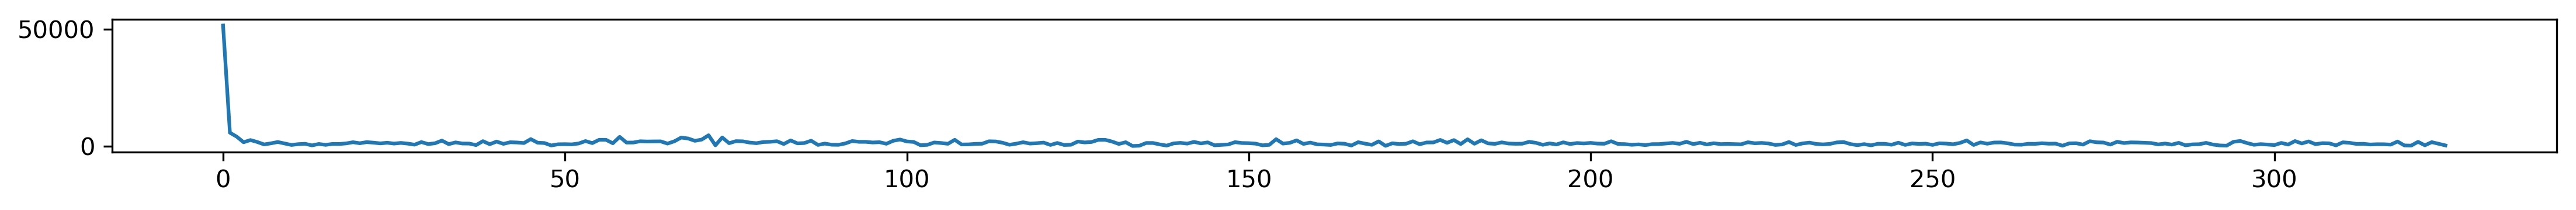

In [40]:
acc_z_fft = scipy.fftpack.fft(Data.loc[:,'acc_z'].values-1000)
plt.plot(np.abs(acc_z_fft)[:int(len(acc_z_fft)/2)])

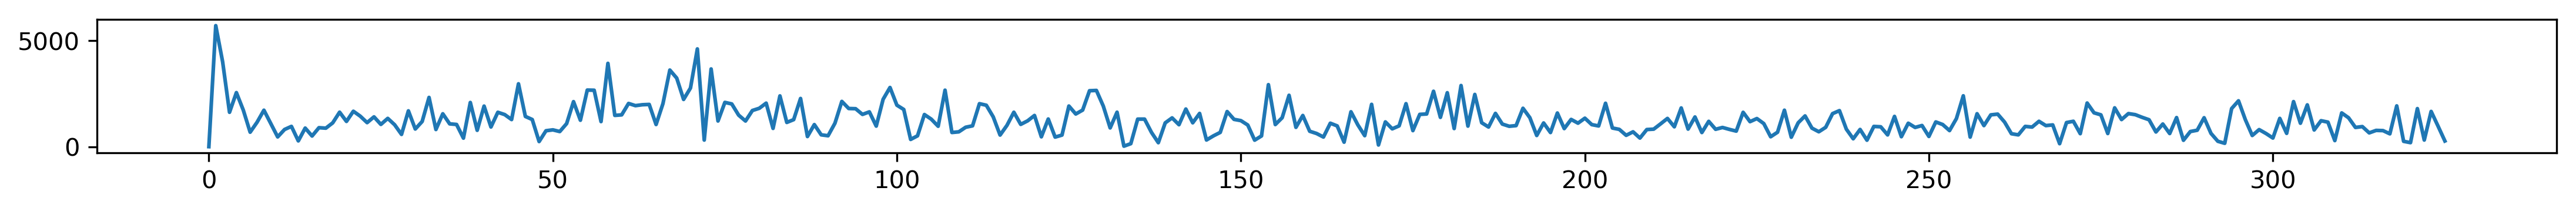

In [41]:
acc_z_fft = scipy.fftpack.fft(Data.loc[:,'acc_z'].values-1000)
b = acc_z_fft
b[:1] = 0
b[-1:] = 0
plt.plot(np.abs(acc_z_fft)[:int(len(b)/2)])

/Users/apple/anaconda3/envs/py36/lib/python3.7/site-packages/ipykernel_launcher.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  import sys


Text(0, 0.5, 'acceleration (mg)')

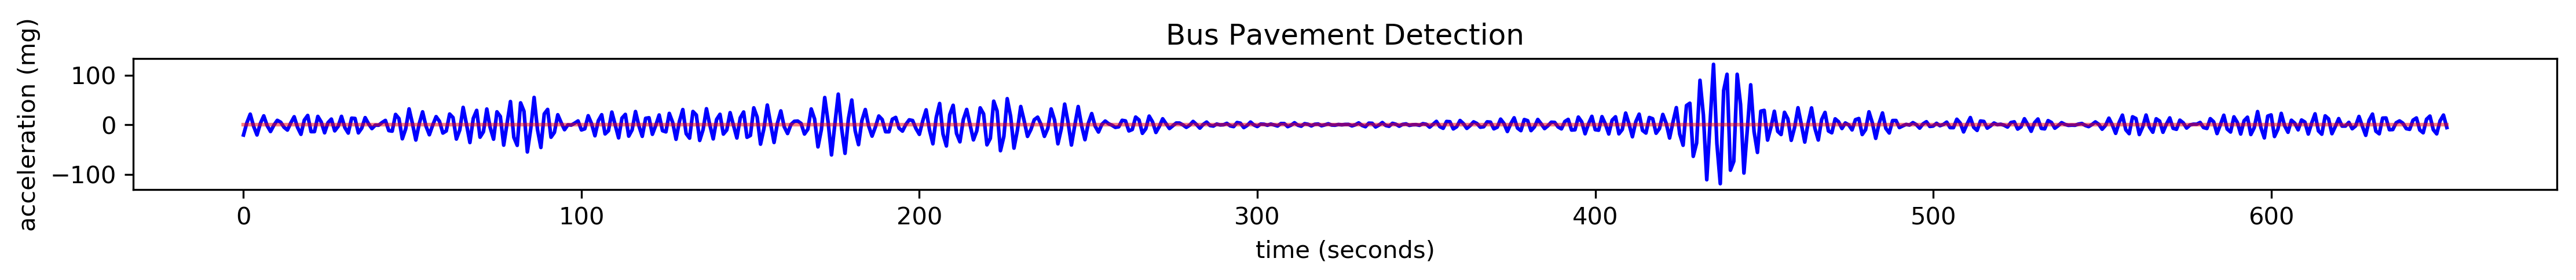

In [42]:
acc_z_fft = scipy.fftpack.fft(Data.loc[:,'acc_z'].values-1000)
b = acc_z_fft
b[200:-200] = 0
b[:150] = 0
b[-150:] = 0
c = scipy.fftpack.ifft(b)
Data['acc_z_pavement'] = c.astype(float)
plt.plot(c,c='b')
plt.plot(np.zeros(len(c)),alpha=0.5,c='r')
plt.title('Bus Pavement Detection')
plt.xlabel('time (seconds)')
plt.ylabel('acceleration (mg)')

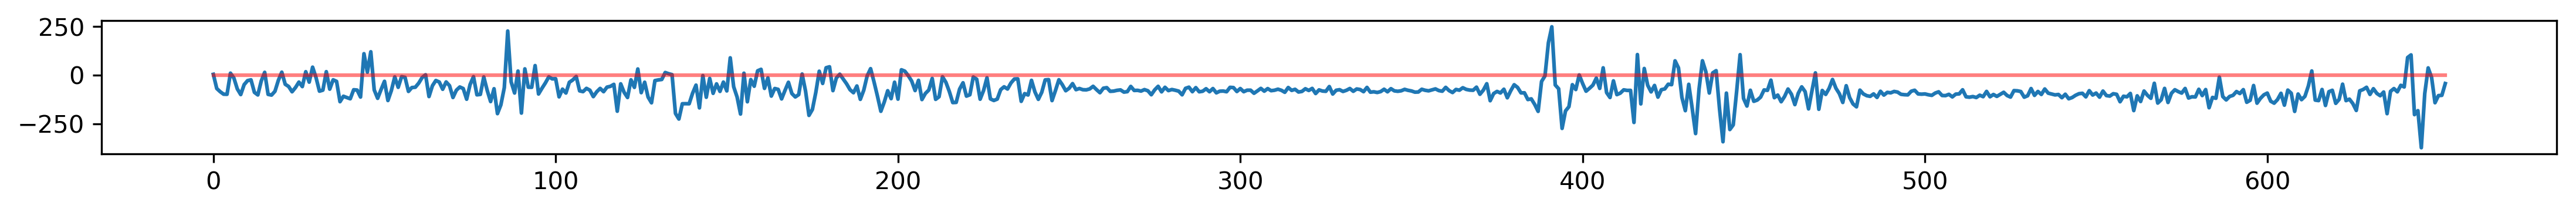

In [46]:
#have a look at acc_z
plt.plot(Data.loc[:,'acc_z'].values-1000)
plt.plot(np.zeros(len(c)),alpha=0.5,c='r')

/Users/apple/anaconda3/envs/py36/lib/python3.7/site-packages/ipykernel_launcher.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  import sys


Text(0, 0.5, 'acceleration (mg)')

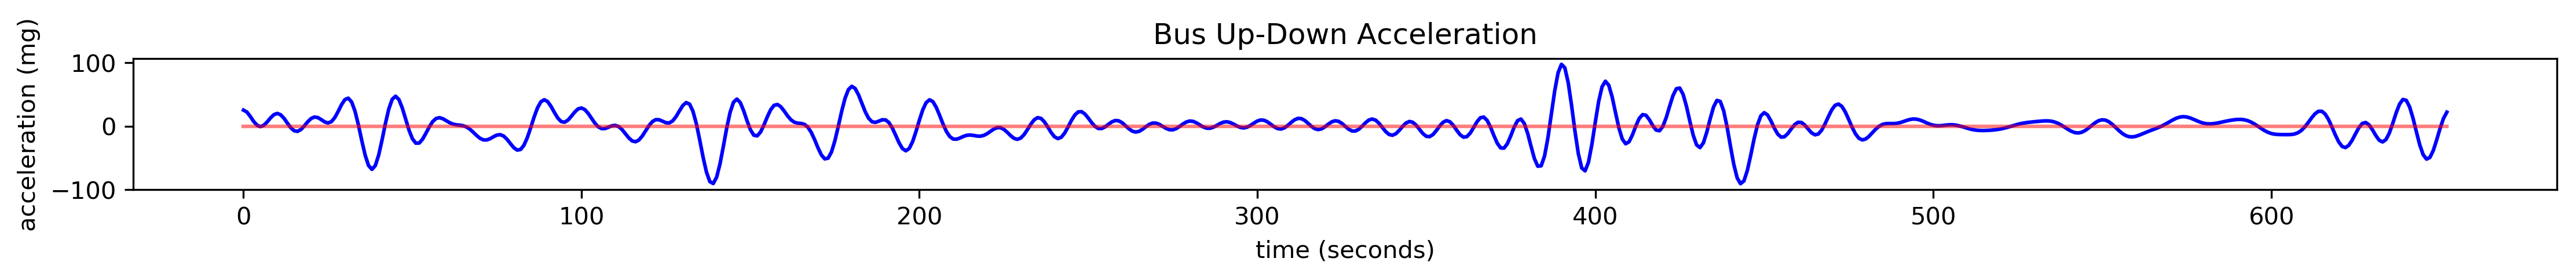

In [44]:
acc_z_fft = scipy.fftpack.fft(Data.loc[:,'acc_z'].values-1000)
b = acc_z_fft
b[60:-60] = 0
b[:5] = 0
b[-5:] = 0
c = scipy.fftpack.ifft(b)
Data['acc_z_altitude'] = c.astype(float)
plt.plot(c,c='b')
plt.plot(np.zeros(len(c)),alpha=0.5,c='r')
plt.title('Bus Up-Down Acceleration')
plt.xlabel('time (seconds)')
plt.ylabel('acceleration (mg)')

Text(0, 0.5, 'Altitude (m)')

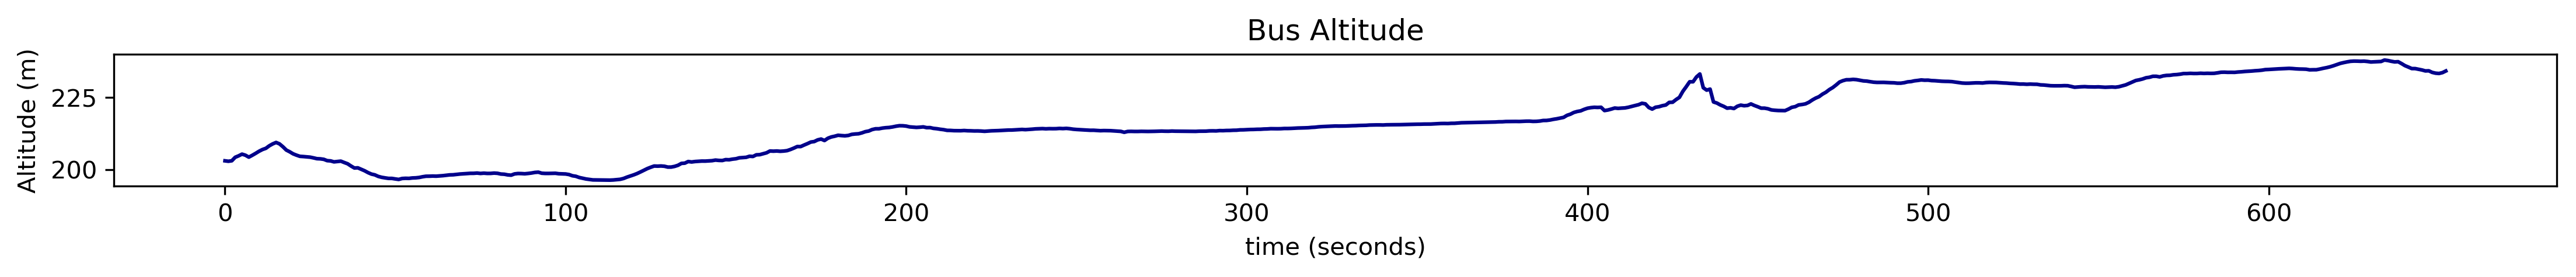

In [45]:
plt.plot(Data.loc[:,'Altitude'].values,c='darkblue')
plt.title('Bus Altitude')
plt.xlabel('time (seconds)')
plt.ylabel('Altitude (m)')

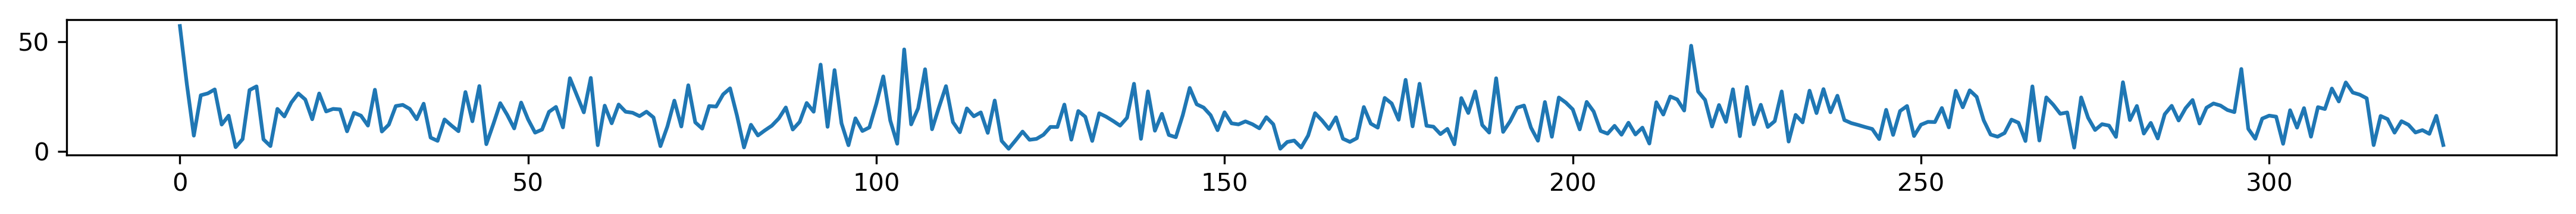

In [52]:
gyro_y_fft = scipy.fftpack.fft(Data.loc[:,'gyro_y'].values)
plt.plot(np.abs(gyro_x_fft)[:int(len(gyro_y_fft)/2)])

/Users/apple/anaconda3/envs/py36/lib/python3.7/site-packages/ipykernel_launcher.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  import sys


Text(0, 0.5, 'turning speed (deg/sec)')

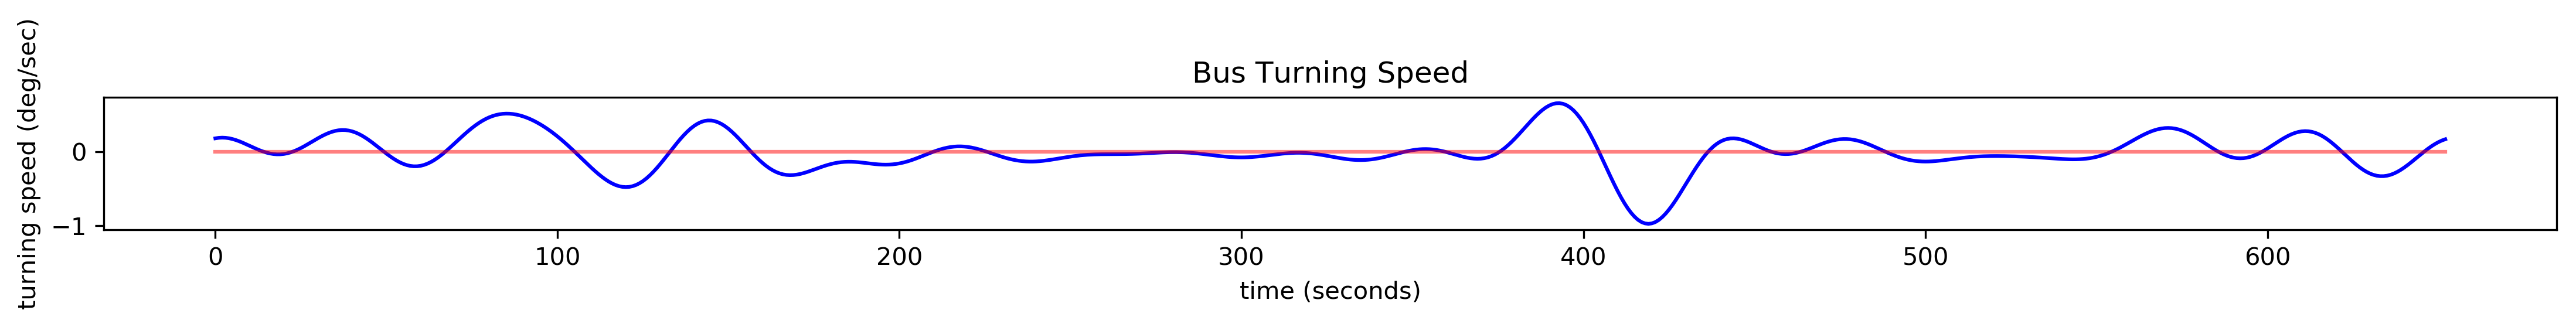

In [53]:
gyro_y_fft = scipy.fftpack.fft(Data.loc[:,'gyro_y'].values)
b = gyro_y_fft
b[20:-20] = 0
#b[:1] = 0
#b[-1:] = 0
c = scipy.fftpack.ifft(b)
Data['gyro_y_turning'] = c.astype(float)
plt.plot(c,c='b')
plt.plot(np.zeros(len(c)),alpha=0.5,c='r')
plt.title('Bus Turning Speed')
plt.xlabel('time (seconds)')
plt.ylabel('turning speed (deg/sec)')

In [55]:
plt.rcParams['figure.figsize'] = (5.0,5.0)
plt.rcParams['savefig.dpi'] = 500
plt.rcParams['figure.dpi'] = 120

In [57]:
Data.head(1)

Longitude   Latitude  Altitude                             Time    Speed  \
0 -83.738361  42.290189   203.071 2019-12-09 20:40:53.970000+00:00  0.87102   

              s         u         v  acc_x  acc_y       ...         mag_z  \
0  1.575924e+09  0.052498 -0.005774   6.96 -25.33       ...        324.64   

   temp                                           geometry  acc_x_oscillation  \
0  25.5  LINESTRING (-83.73836111999999 42.29018889, -8...         -49.380983   

   acc_x_direction  acc_y_oscillation  acc_y_fb  acc_z_pavement  \
0         5.817987         -17.554908 -1.539365         1003.48   

  acc_z_altitude  gyro_y_turning  
0      25.262296        0.178285  

[1 rows x 26 columns]

In [58]:
intersection = gpd.GeoDataFrame()
station = gpd.GeoDataFrame()
intersection['geometry'] = [Point(-83.7383209,42.2897753),
                            Point(-83.7357889,42.2887356),
                            Point(-83.733353,42.287632),
                            Point(-83.732497,42.286488),
                            Point(-83.727672,42.284895),
                            Point(-83.727103,42.283879),
                            Point(-83.728506,42.281464),
                            Point(-83.729862,42.281425),
                            Point(-83.731096,42.281369),
                            Point(-83.731090,42.280435),
                            Point(-83.731011,42.277499),
                            Point(-83.733419,42.277407)]
station['geometry'] = [Point(-83.736881,42.289152),
                       Point(-83.733610,42.287719),
                       Point(-83.730949,42.285298),
                       Point(-83.727344,42.284044),
                       Point(-83.728975,42.281512),
                       Point(-83.731121,42.279980),
                       Point(-83.731110,42.278504)]

Text(0.5, 1.0, 'Bus Left-Right Vibration')

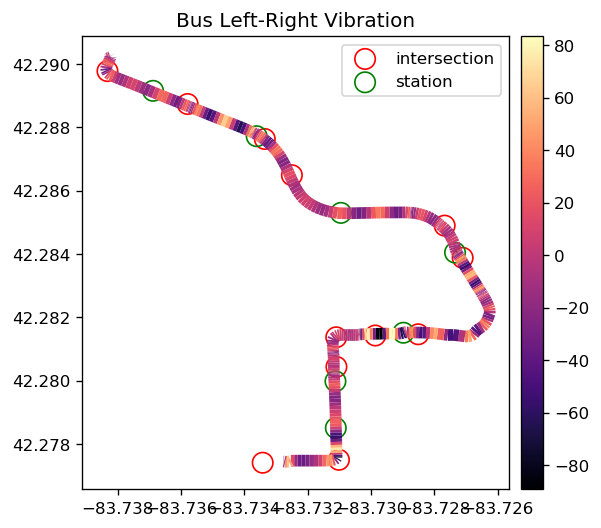

In [59]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig1, ax1 = plt.subplots(1, 1)
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.1)
Data.plot(column='acc_x_oscillation',linewidth=7, ax=ax1, legend=True, cmap='magma',vmin=Data['acc_x_oscillation'].min(),vmax=Data['acc_x_oscillation'].max(),cax=cax)
#Data.iloc[50:60,:].plot(ax=ax1,column='acc_y',linewidth=10)
intersection.plot(ax=ax1, facecolors='none', edgecolors='r',markersize=150,label='intersection')
station.plot(ax=ax1, facecolors='none', edgecolors='g',markersize=150,label='station')
ax1.legend()
ax1.set_title('Bus Left-Right Vibration')

Text(0.5, 1.0, 'Bus Left-Right Turning')

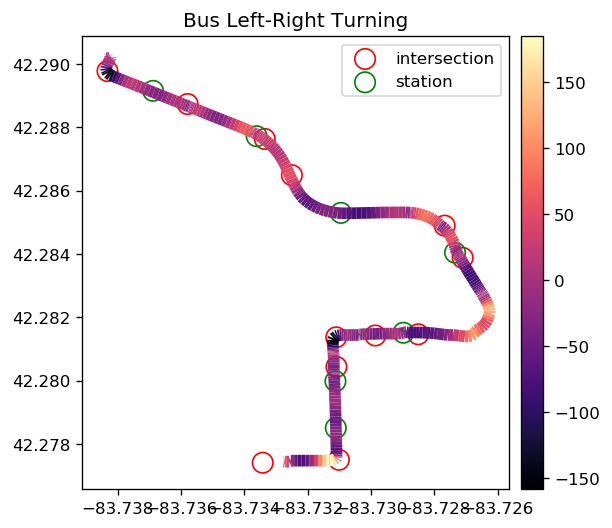

In [60]:
fig1, ax1 = plt.subplots(1, 1)
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.1)
Data.plot(column='acc_x_direction',linewidth=7, ax=ax1, legend=True, cmap='magma',vmin=Data['acc_x_direction'].min(),vmax=Data['acc_x_direction'].max(),cax=cax)
intersection.plot(ax=ax1, facecolors='none', edgecolors='r',markersize=150,label='intersection')
station.plot(ax=ax1, facecolors='none', edgecolors='g',markersize=150,label='station')
ax1.legend()
ax1.set_title('Bus Left-Right Turning')

Text(0.5, 1.0, 'Bus Forward-Backward Vibration')

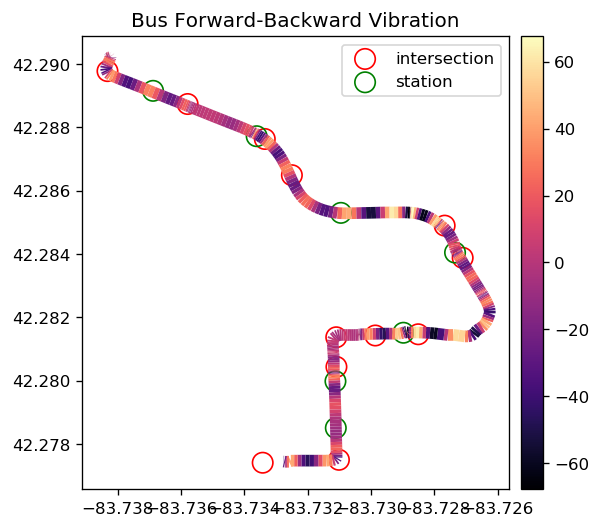

In [61]:
fig1, ax1 = plt.subplots(1, 1)
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.1)
Data.plot(column='acc_y_oscillation',linewidth=7, ax=ax1, legend=True, cmap='magma',vmin=Data['acc_y_oscillation'].min(),vmax=Data['acc_y_oscillation'].max(),cax=cax)
intersection.plot(ax=ax1, facecolors='none', edgecolors='r',markersize=150,label='intersection')
station.plot(ax=ax1, facecolors='none', edgecolors='g',markersize=150,label='station')
ax1.legend()
ax1.set_title('Bus Forward-Backward Vibration')

Text(0.5, 1.0, 'Bus Forward-Backward Acceleration')

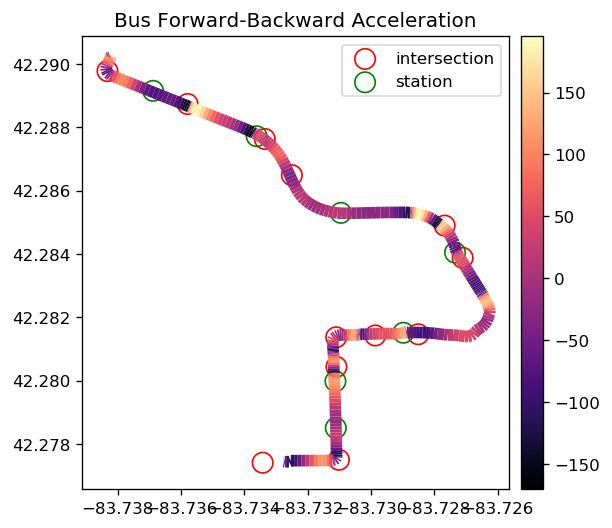

In [62]:
fig1, ax1 = plt.subplots(1, 1)
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.1)
Data.plot(column='acc_y_fb',linewidth=7, ax=ax1, legend=True, cmap='magma',vmin=Data['acc_y_fb'].min(),vmax=Data['acc_y_fb'].max(),cax=cax)
intersection.plot(ax=ax1, facecolors='none', edgecolors='r',markersize=150,label='intersection')
station.plot(ax=ax1, facecolors='none', edgecolors='g',markersize=150,label='station')
ax1.legend()
ax1.set_title('Bus Forward-Backward Acceleration')


Text(0.5, 1.0, 'Bus Pavement Detection')

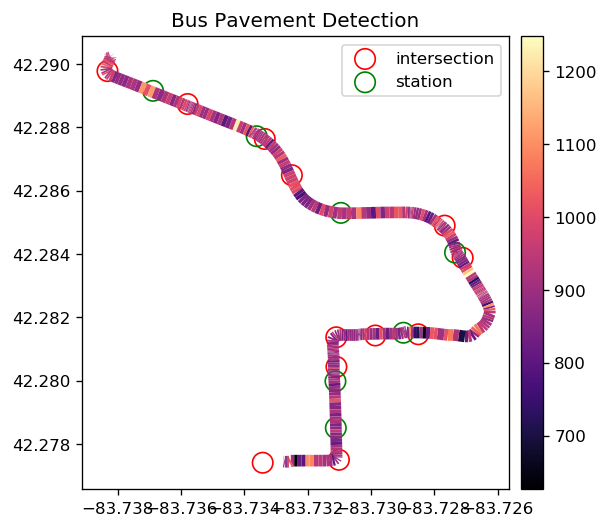

In [63]:
fig1, ax1 = plt.subplots(1, 1)
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.1)
Data.plot(column='acc_z_pavement',linewidth=7, ax=ax1, legend=True, cmap='magma',vmin=Data['acc_z_pavement'].min(),vmax=Data['acc_z_pavement'].max(),cax=cax)
intersection.plot(ax=ax1, facecolors='none', edgecolors='r',markersize=150,label='intersection')
station.plot(ax=ax1, facecolors='none', edgecolors='g',markersize=150,label='station')
ax1.legend()
ax1.set_title('Bus Pavement Detection')

Text(0.5, 1.0, 'Bus Altitude Acceleration')

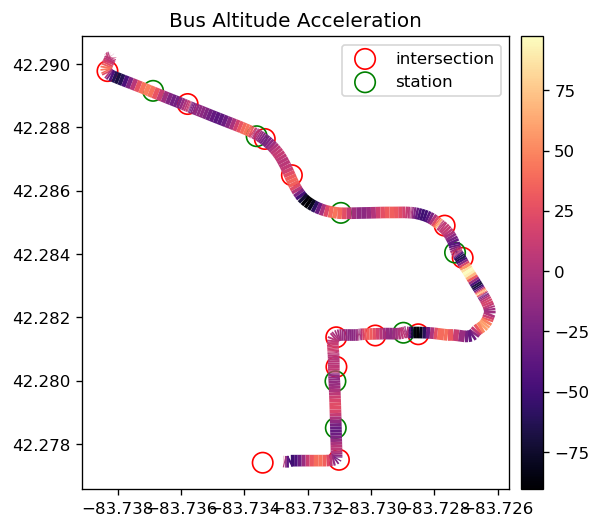

In [64]:
fig1, ax1 = plt.subplots(1, 1)
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.1)
Data.plot(column='acc_z_altitude',linewidth=7, ax=ax1, legend=True, cmap='magma',vmin=Data['acc_z_altitude'].min(),vmax=Data['acc_z_altitude'].max(),cax=cax)
intersection.plot(ax=ax1, facecolors='none', edgecolors='r',markersize=150,label='intersection')
station.plot(ax=ax1, facecolors='none', edgecolors='g',markersize=150,label='station')
ax1.legend()
ax1.set_title('Bus Altitude Acceleration')

Text(0.5, 1.0, 'Bus Turning Speed')

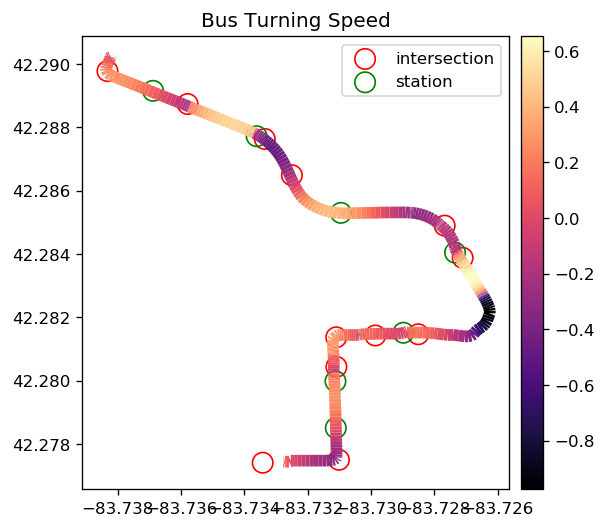

In [65]:
fig1, ax1 = plt.subplots(1, 1)
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.1)
Data.plot(column='gyro_y_turning',linewidth=7, ax=ax1, legend=True, cmap='magma',vmin=Data['gyro_y_turning'].min(),vmax=Data['gyro_y_turning'].max(),cax=cax)
intersection.plot(ax=ax1, facecolors='none', edgecolors='r',markersize=150,label='intersection')
station.plot(ax=ax1, facecolors='none', edgecolors='g',markersize=150,label='station')
ax1.legend()
ax1.set_title('Bus Turning Speed')

In [66]:
data.to_csv('20191209BUS23EW.csv')